In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import soundfile
import pickle

from audiomentations import Compose, TimeStretch, PitchShift, Shift, Trim, Gain, PolarityInversion
from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append("../../../")
from utils.segmentation import segment_cough
import sounddevice as sd

In [3]:
### Setup paths and directories
dataset_path = ".."
rawdata_path = os.path.join(dataset_path, "Extracted_data")
out_path = "raw"
metadata_path = os.path.join(dataset_path, "combined_data.csv")

In [4]:
metadata = pd.read_csv(metadata_path, sep = ",")

metadata["covid"] = 'X'
metadata.loc[metadata["covid_status"] == "healthy", "covid"] = 0
metadata.loc[(metadata["covid_status"] == "positive_mild") | (metadata["covid_status"] == "positive_moderate"), "covid"] = 1
metadata = metadata.loc[metadata["covid"] != 'X']

print(metadata[['covid','id']].groupby(['covid']).count().rename(columns={'id':'N_entries'}))


       N_entries
covid           
0           1433
1            591


example

In [5]:
sample_rate = 48000
sample_path = os.path.join(rawdata_path, metadata["id"][3], "cough-heavy.wav")
sample, _ = librosa.load(sample_path, sr = 48000)

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


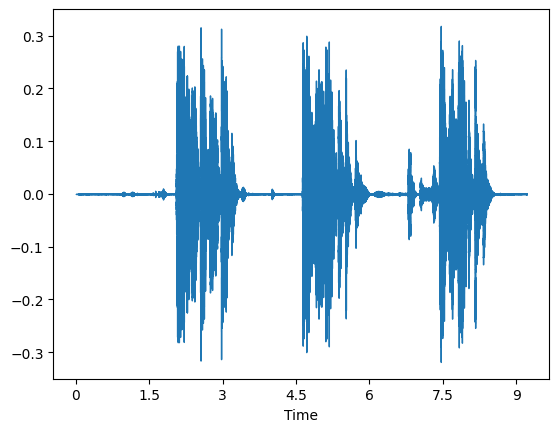

In [6]:
librosa.display.waveshow(y = sample, sr = sample_rate)
sd.play(sample, sample_rate)

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun o

Text(0.5, 1.0, 'Segmentation Output')

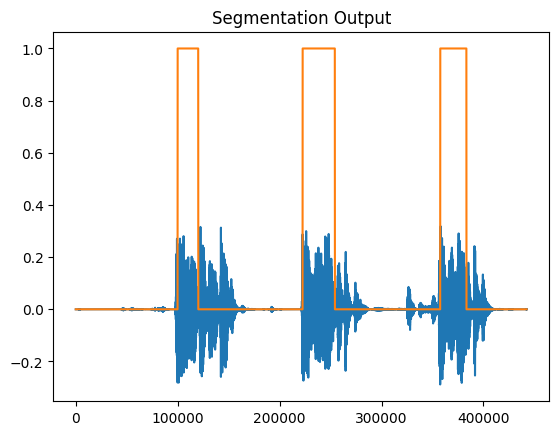

In [7]:
cough_segments, cough_mask = segment_cough(sample, sample_rate, cough_padding=0)

plt.plot(sample)
plt.plot(cough_mask)
plt.title("Segmentation Output")

In [8]:
sd.play(cough_segments[0], sample_rate)

Preprocess

In [9]:
data = {
    "filename": [],
    "signal": [],
    "label": []
}

sample_rate = 48000

for uuid, covid in tqdm(zip(metadata["id"].values, metadata["covid"].values), total = len(metadata)):

    file_path = os.path.join(rawdata_path, uuid, "cough-heavy.wav")
    
    if not os.path.exists(file_path):
        print(f"could not find audio file for uuid: {uuid}")
        continue

    signal, sr = librosa.load(file_path, sr = None)

    if signal.size == 0:
        print("Empty audio")
        continue

    if  sr != sample_rate:
        print("Resampling...")
        signal = librosa.resample(signal, orig_sr = sr, target_sr = sample_rate)


    cough_segments, cough_mask = segment_cough(signal, sample_rate, cough_padding=0)

    for i, seg in enumerate(cough_segments):
        data["filename"].append(uuid + f"_seg_{i}")
        data["signal"].append(seg)
        data["label"].append(covid)


  0%|          | 0/2024 [00:00<?, ?it/s]

Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Resampling...
Empty audio
Resampling...
Resampling...
Resampling...
Empty audio


KeyboardInterrupt: 

In [10]:
print("all:", len(data["signal"]))
print("negative:", sum(np.asarray(data["label"]) == 0))
print("positive:",sum(np.asarray(data["label"]) == 1))

all: 4434
negative: 3343
positive: 1091


In [79]:
with open("segments.pkl", "wb") as f:
    pickle.dump(data, f)

In [9]:
with open("segments.pkl", "rb") as f:
    data = pickle.load(f)

(array([599., 542., 561., 462., 421., 336., 299., 257., 193., 153., 102.,
         84.,  61.,  55.,  54.,  33.,  27.,  26.,  16.,   5.,  13.,  19.,
         14.,   7.,   9.,  12.,   7.,   4.,   9.,   7.,   4.,   8.,   4.,
          4.,   3.,   2.,   3.,   2.,   4.,   1.,   0.,   2.,   0.,   2.,
          1.,   1.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  9602.  ,  10569.82,  11537.64,  12505.46,  13473.28,  14441.1 ,
         15408.92,  16376.74,  17344.56,  18312.38,  19280.2 ,  20248.02,
         21215.84,  22183.66,  23151.48,  24119.3 ,  25087.12,  26054.94,
         27022.76,  27990.58,  28958.4 ,  29926.22,  30894.04,  31861.86,
         32829.68,  33

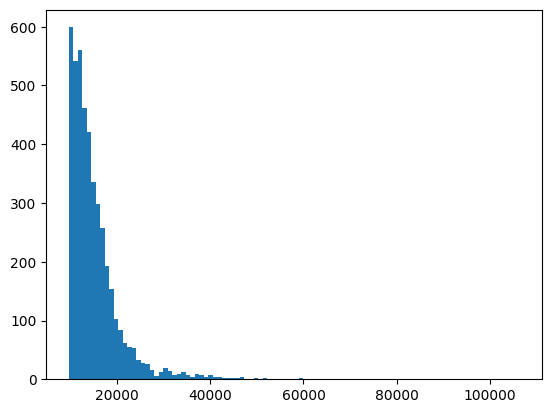

In [11]:
lengths = [len(x) for x in data["signal"]]
plt.hist(lengths, 100)

In [12]:
lengths = np.asarray(lengths)
np.sum(lengths < 30720) / len(lengths)

0.972936400541272

In [13]:
fix_length = 30720

In [14]:
fix_length_signals = [librosa.util.fix_length(x, size = fix_length) for x in data["signal"]]

In [15]:
cropped = {
    "filename": data["filename"],
    "signal": fix_length_signals,
    "label": data["label"]
}

In [16]:
with open("cropped_30720.pkl", "wb") as f:
    pickle.dump(cropped, f)

In [12]:
with open("cropped_30720.pkl", "rb") as f:
    cropped = pickle.load(f)

In [17]:
signals = np.asarray(cropped["signal"])

Normalization

(array([   9.,   35.,  112.,  224., 1520., 1786.,  669.,   39.,   23.,
          17.]),
 array([0.17352295, 0.30839887, 0.4432748 , 0.5781507 , 0.71302664,
        0.84790254, 0.98277843, 1.1176543 , 1.2525303 , 1.3874062 ,
        1.5222821 ], dtype=float32),
 <BarContainer object of 10 artists>)

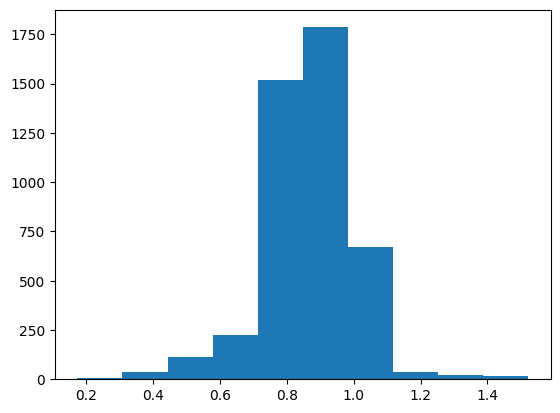

In [18]:
plt.hist(np.abs(signals).max(axis=1))

In [19]:
signals_small = signals[np.abs(signals).max(axis=1) < 0.3]
signals_small.shape

(9, 30720)

In [20]:
sample = signals_small[0]
sd.play(sample)

In [21]:
sample_norm = sample / np.abs(sample).max()
print(np.abs(sample_norm).max())
sd.play(sample_norm)

1.0


In [22]:
signals_norm = signals / np.abs(signals).max(axis = 1)[:, np.newaxis]

In [23]:
normalized = cropped
normalized["signal"] = signals_norm

In [24]:
with open("normalized.pkl", "wb") as f:
    pickle.dump(normalized, f)

MFCC

In [25]:
n_mfcc = 39
frame_length = 2048
hop_length = frame_length // 2
mfccs = librosa.feature.mfcc(y = signals_norm, n_mfcc = n_mfcc, n_fft = frame_length, hop_length = hop_length)
mfccs.shape

(4434, 39, 31)

In [26]:
filename = f"mfcc39_fixlength_{fix_length}_nmfcc_{n_mfcc}_framelength_{frame_length}_hoplength_{hop_length}.npy"
np.save(filename, mfccs)